
=== Blobs (isotropic) ===


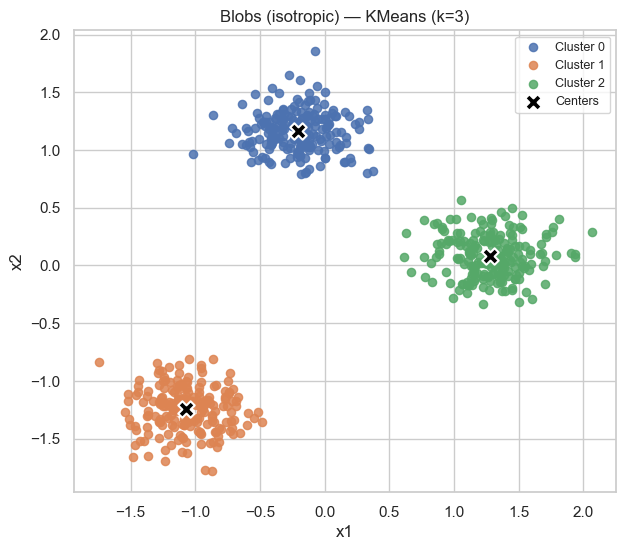

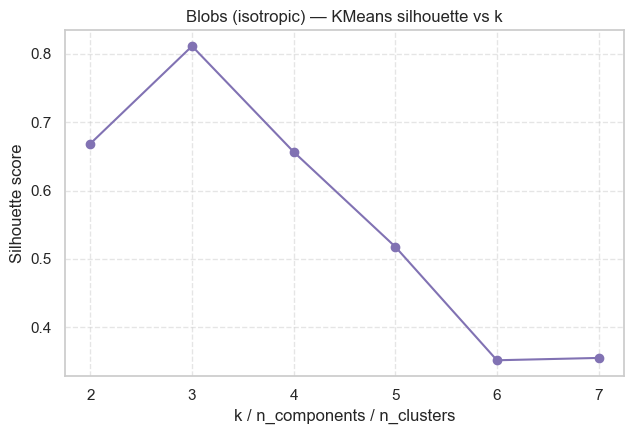

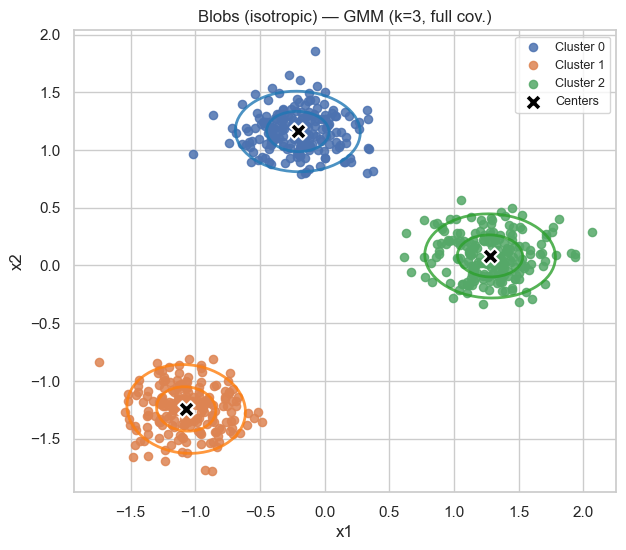

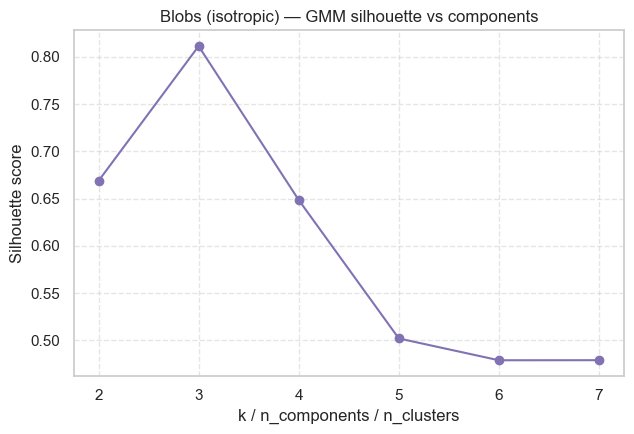

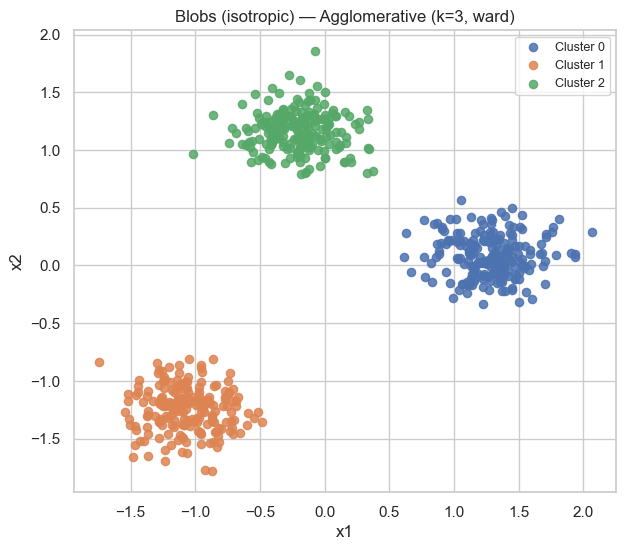

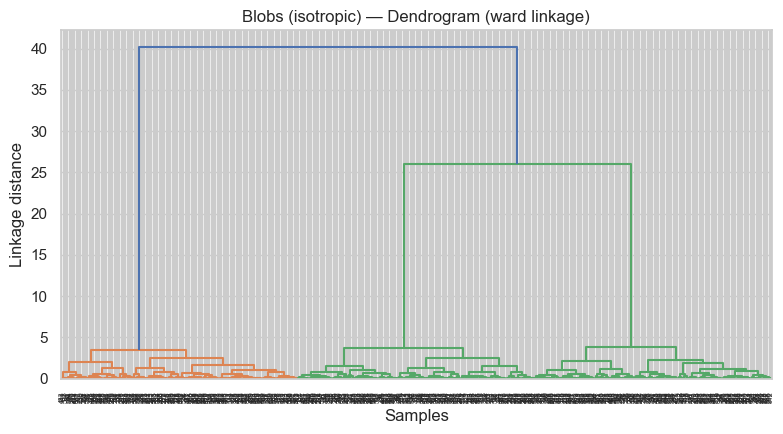


=== Blobs (anisotropic) ===


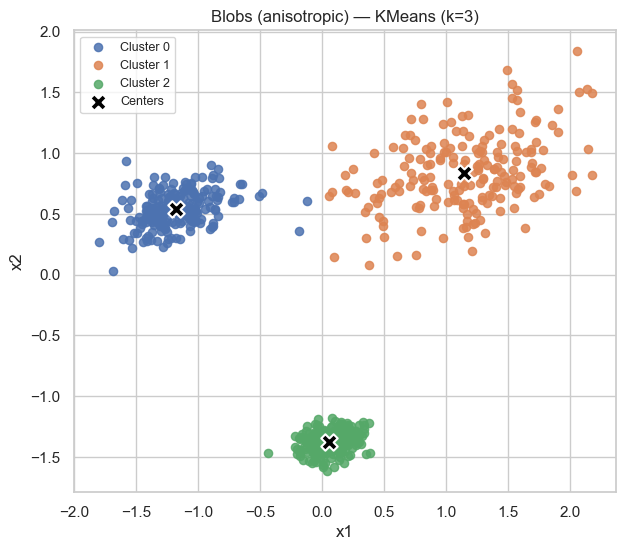

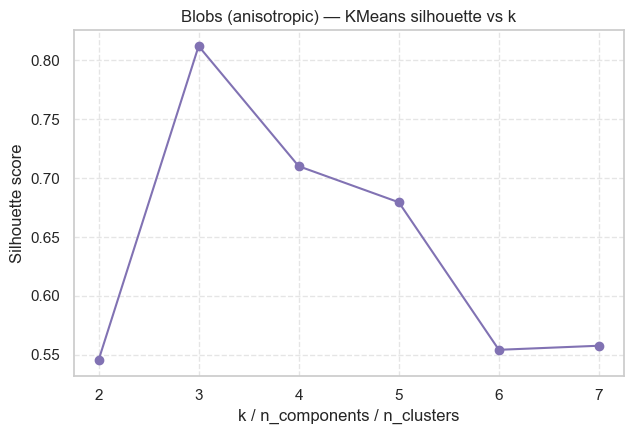

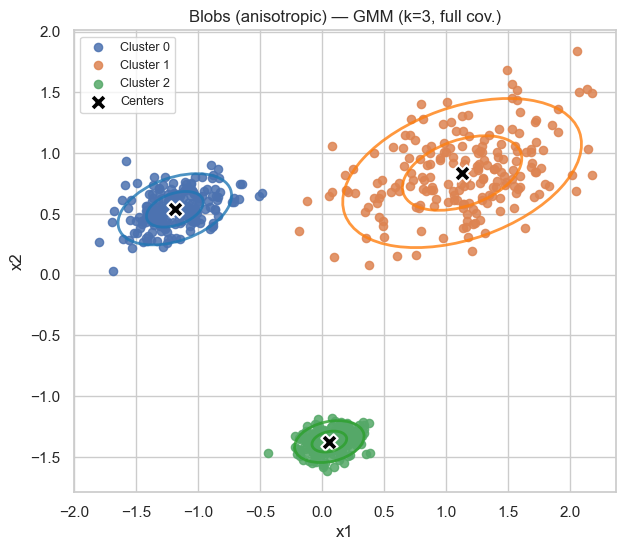

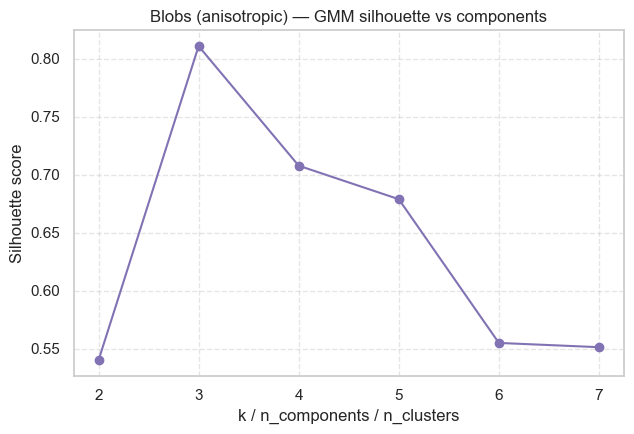

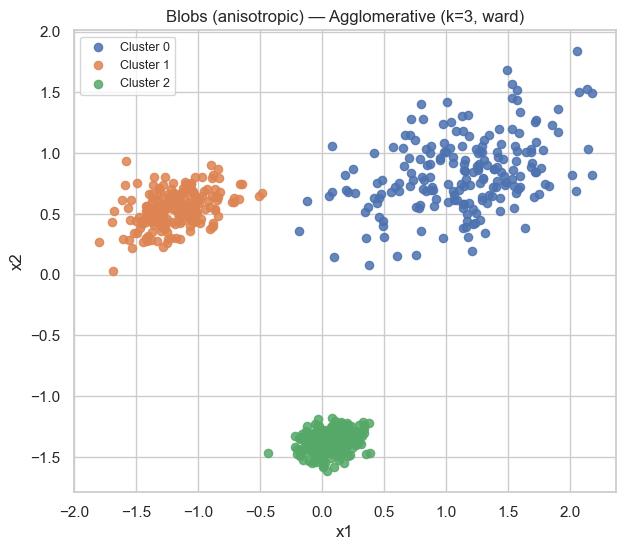

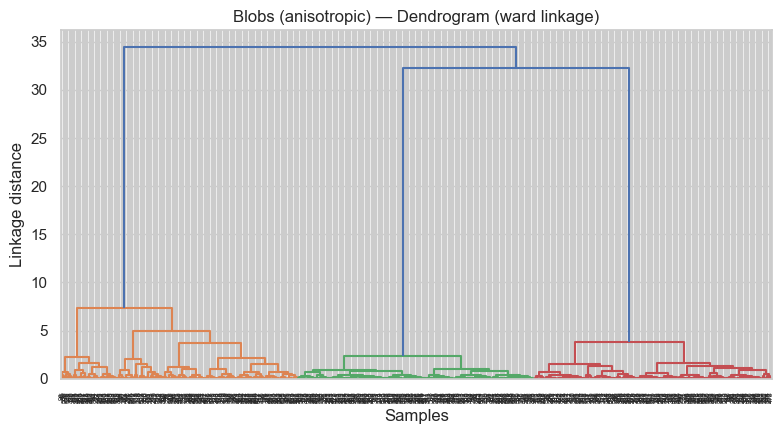


=== Two Moons ===


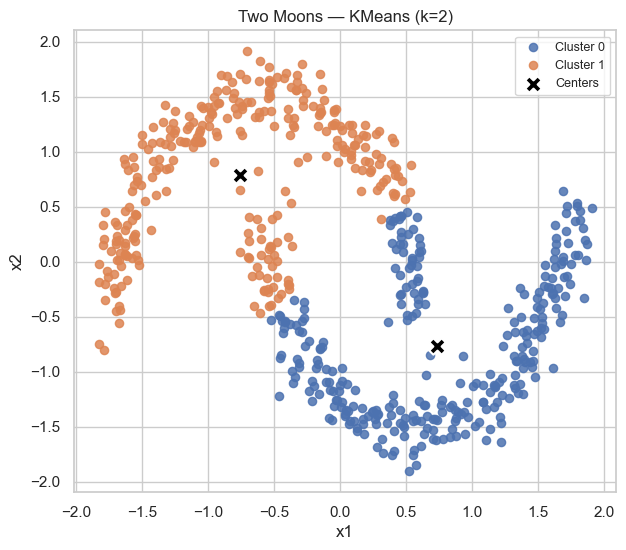

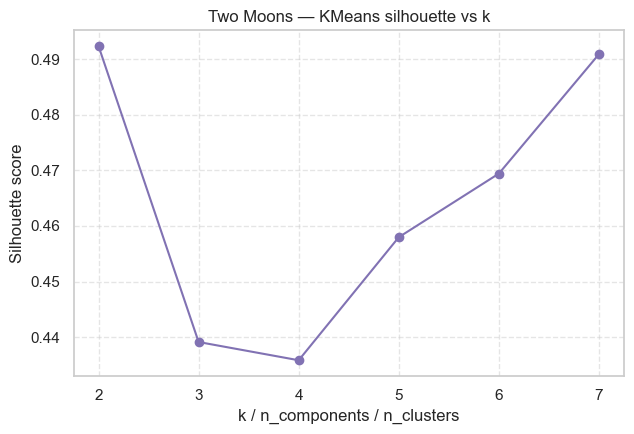

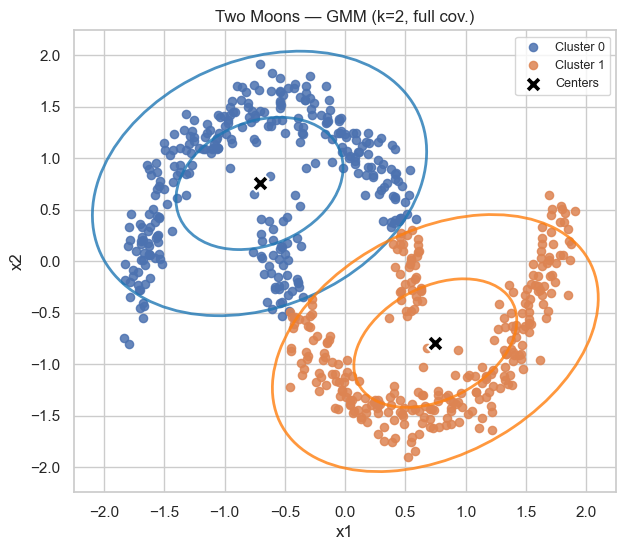

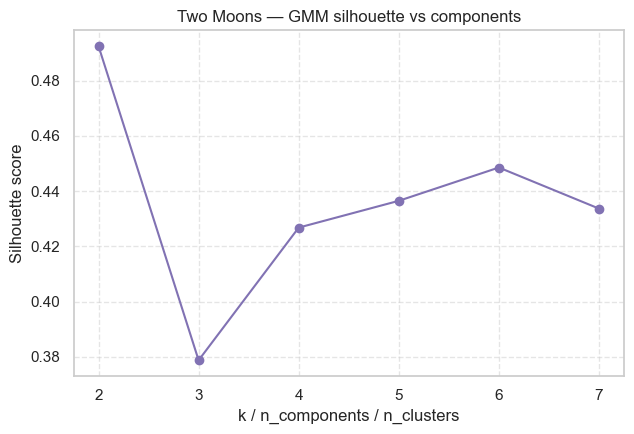

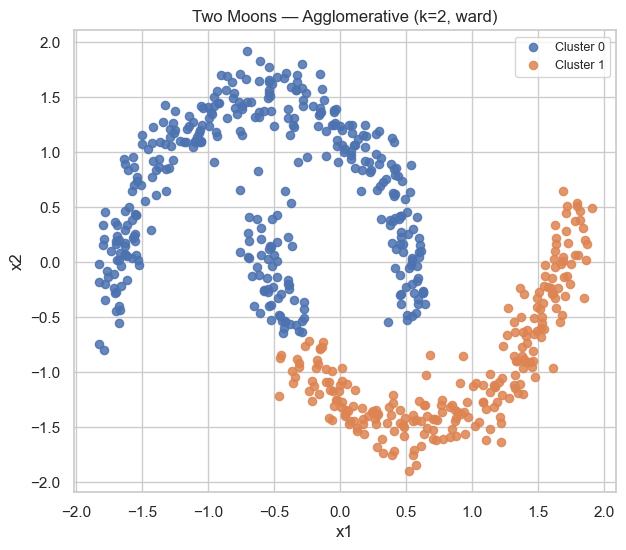

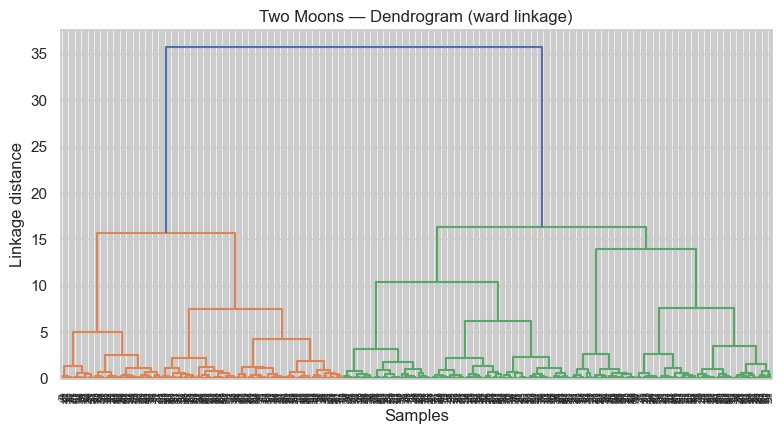

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set(context="notebook", style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7, 6)
RNG = 42


# Utility: plotting helpers

def plot_clusters(X, labels, centers=None, title="Clusters", ax=None, palette="tab10"):
    ax = ax or plt.gca()
    uniq = np.unique(labels)
    for u in uniq:
        ax.scatter(X[labels == u, 0], X[labels == u, 1], s=35, alpha=0.85, label=f"Cluster {u}")
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], c="black", s=140, marker="X", edgecolor="white", linewidth=1.5, label="Centers")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="best", fontsize=9)
    return ax

def draw_gmm_ellipses(ax, gmm, colors=None, scale=1.0):
    # Plot covariance ellipses for 2D GMM components
    import matplotlib as mpl
    means = gmm.means_
    covs = gmm.covariances_
    if covs.ndim == 1:  # spherical
        covs = np.array([np.eye(means.shape[1]) * c for c in covs])
    elif covs.ndim == 2:  # tied
        covs = np.array([covs for _ in range(gmm.n_components)])
    # else: diag or full are already per-component matrices

    for i, (mean, cov) in enumerate(zip(means, covs)):
        if mean.shape[0] != 2:
            continue  # only plot in 2D
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        # Draw 1- and 2-std ellipses
        for nsig in [1.0, 2.0]:
            w, h = 2 * nsig * np.sqrt(vals)
            e = mpl.patches.Ellipse(mean, width=w*scale, height=h*scale, angle=angle,
                                    edgecolor=colors[i] if colors is not None else "#333333",
                                    facecolor="none", lw=2, alpha=0.8)
            ax.add_patch(e)

def silhouette_scan(X, algo_name, fit_callable, k_values, metric="euclidean"):
    scores = []
    for k in k_values:
        labels = fit_callable(k)
        if len(np.unique(labels)) < 2:
            scores.append(np.nan)
        else:
            scores.append(silhouette_score(X, labels, metric=metric))
    return np.array(scores)

def plot_silhouette_curve(k_values, scores, title):
    plt.figure(figsize=(6.5, 4.5))
    plt.plot(k_values, scores, marker="o", color="#8172B3")
    plt.title(title)
    plt.xlabel("k / n_components / n_clusters")
    plt.ylabel("Silhouette score")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_dendrogram(X, method="ward", max_d=None, title="Hierarchical Dendrogram"):
    Z = linkage(X, method=method)
    plt.figure(figsize=(8, 4.5))
    dendrogram(Z, truncate_mode=None, p=30, color_threshold=max_d)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Linkage distance")
    if max_d is not None:
        plt.axhline(max_d, c="red", ls="--", lw=1)
    plt.tight_layout()
    plt.show()
    return Z


# Algorithms: wrappers

def run_kmeans(X, k, random_state=RNG, n_init=10):
    km = KMeans(n_clusters=k, init="k-means++", n_init=n_init, random_state=random_state)
    labels = km.fit_predict(X)
    return km, labels

def run_gmm(X, k, random_state=RNG, covariance_type="full"):
    gmm = GaussianMixture(n_components=k, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)
    return gmm, labels

def run_agglomerative(X, k, linkage_kind="ward"):
    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage_kind)
    labels = agg.fit_predict(X)
    return agg, labels


# Datasets

def make_datasets():
    rng = np.random.RandomState(RNG)

    # 1) Isotropic blobs
    Xb, yb = make_blobs(n_samples=600, centers=3, cluster_std=1.2, random_state=RNG)

    # 2) Anisotropic blobs via linear transform
    Xb2, yb2 = make_blobs(n_samples=600, centers=3, cluster_std=[1.0, 2.0, 0.6], random_state=RNG)
    transform = np.array([[0.6, -0.4], [1.2, 0.8]])
    Xa = Xb2 @ transform.T
    ya = yb2

    # 3) Two moons (non-linearly separable)
    Xm, ym = make_moons(n_samples=600, noise=0.08, random_state=RNG)

    return [
        ("Blobs (isotropic)", Xb, yb, 3),
        ("Blobs (anisotropic)", Xa, ya, 3),
        ("Two Moons", Xm, ym, 2),
    ]


# Main workflow

def analyze_dataset(name, X, y_true, k_default):
    print(f"\n=== {name} ===")
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # --- KMeans ---
    km, km_labels = run_kmeans(Xs, k_default)
    fig, ax = plt.subplots()
    plot_clusters(Xs, km_labels, centers=km.cluster_centers_, title=f"{name} — KMeans (k={k_default})", ax=ax)
    plt.show()

    # silhouette over k for KMeans
    k_vals = list(range(2, 8))
    km_scores = silhouette_scan(
        Xs, "kmeans",
        fit_callable=lambda kk: run_kmeans(Xs, kk)[1],
        k_values=k_vals
    )
    plot_silhouette_curve(k_vals, km_scores, title=f"{name} — KMeans silhouette vs k")

    #  GMM 
    gmm, gmm_labels = run_gmm(Xs, k_default, covariance_type="full")
    fig, ax = plt.subplots()
    ax = plot_clusters(Xs, gmm_labels, centers=gmm.means_, title=f"{name} — GMM (k={k_default}, full cov.)", ax=ax)
    # draw covariance ellipses
    palette = sns.color_palette("tab10", n_colors=gmm.n_components)
    draw_gmm_ellipses(ax, gmm, colors=palette, scale=1.0)
    plt.show()

    # silhouette over components for GMM
    gmm_scores = silhouette_scan(
        Xs, "gmm",
        fit_callable=lambda kk: run_gmm(Xs, kk, covariance_type="full")[1],
        k_values=k_vals
    )
    plot_silhouette_curve(k_vals, gmm_scores, title=f"{name} — GMM silhouette vs components")

    # --- Agglomerative (Hierarchical) ---
    agg, agg_labels = run_agglomerative(Xs, k_default, linkage_kind="ward")
    fig, ax = plt.subplots()
    plot_clusters(Xs, agg_labels, centers=None, title=f"{name} — Agglomerative (k={k_default}, ward)", ax=ax)
    plt.show()

    # dendrogram (Ward linkage on standardized data)
    Z = plot_dendrogram(Xs, method="ward", max_d=None, title=f"{name} — Dendrogram (ward linkage)")

if __name__ == "__main__":
    datasets = make_datasets()
    for name, X, y, k in datasets:
        analyze_dataset(name, X, y, k)
